# Distillation Tower Simulator

ODEINT simulator with noise added

Text(0.5, 0, 'Time (min)')

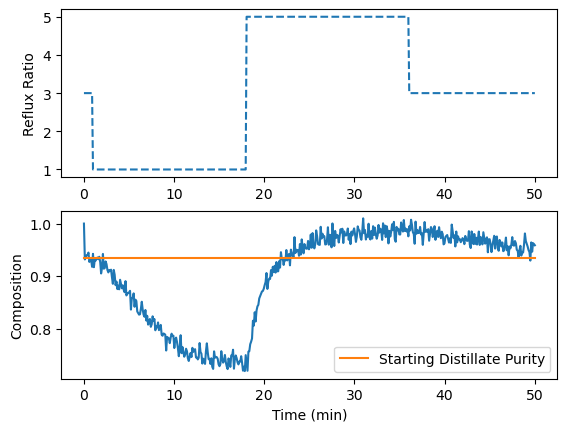

In [72]:
import random
from gekko import GEKKO
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

def distill_noise(x,t,rr,Feed,x_Feed):
    # Inputs (3):
    # Reflux ratio is the Manipulated variable
    # Reflux Ratio (L/D)
    #rr = p(1)

    # Disturbance variables (DV)
    # Feed Flowrate (mol/min)
    #Feed = p(2)

    # Mole Fraction of Feed
    #x_Feed = p(3)

    # States (32):
    # x(0) - Reflux Drum Liquid Mole Fraction of Component A
    # x(1) - Tray 1 - Liquid Mole Fraction of Component A
    # .
    # .
    # .
    # x(16) - Tray 16 - Liquid Mole Fraction of Component A (Feed)
    # .
    # .
    # .
    # x(30) - Tray 30 - Liquid Mole Fraction of Component A
    # x(31) - Reboiler Liquid Mole Fraction of Component A

    # Parameters
    # Distillate Flowrate (mol/min)
    D=0.5*Feed
    # Flowrate of the Liquid in the Rectification Section (mol/min)
    L=rr*D
    # Vapor Flowrate in the Column (mol/min)
    V=L+D
    # Flowrate of the Liquid in the Stripping Section (mol/min)
    FL=Feed+L
    # Relative Volatility = (yA/xA)/(yB/xB) = KA/KB = alpha(A,B)
    vol=1.6
    # Total Molar Holdup in the Condenser
    atray=0.25
    # Total Molar Holdup on each Tray
    acond=0.5
    # Total Molar Holdup in the Reboiler
    areb=1.0
    
    #% To Equilbrium
    #Eq = 0.8 TO ADD LATER
    
    # Vapor Mole Fractions of Component A
    # From the equilibrium assumption and mole balances
    # 1) vol = (yA/xA) / (yB/xB)
    # 2) xA + xB = 1
    # 3) yA + yB = 1
    y = np.empty(len(x))
    for i in range(32):
        y[i] = x[i] * vol/(1.0+(vol-1.0)*x[i])

    # Compute xdot
    xdot = np.empty(len(x))
    xdot[0] = 1/acond*V*(y[1]-x[0])
    for i in range(1,16):
        xdot[i] = 1.0/atray*(L*(x[i-1]-x[i])-V*(y[i]-y[i+1]))
    xdot[16] = 1/atray*(Feed*x_Feed+L*x[15]-FL*x[16]-V*(y[16]-y[17]))
    for i in range(17,31):
        xdot[i] = 1.0/atray*(FL*(x[i-1]-x[i])-V*(y[i]-y[i+1]))
    xdot[31] = 1/areb*(FL*x[30]-(Feed-D)*x[31]-V*y[31])
    return xdot

def simulate(t,rr,ff,xf,x_ss):
    x0 = x_ss
    xd = np.ones(len(t))
    for i in range(len(t)-1):
        ts = [t[i],t[i+1]]
        y = odeint(distill_noise,x0,ts,args=(rr[i],ff[i],xf[i]))
        xd[i+1] = y[-1][0]+0.01*np.random.normal()
        x0 = y[-1]
    return xd
        
# Steady State Initial Conditions for the 32 states
x_ss =np.array([0.935,0.900,0.862,0.821,0.779,0.738,\
0.698,0.661,0.628,0.599,0.574,0.553,0.535,0.521,    \
0.510,0.501,0.494,0.485,0.474,0.459,0.441,0.419,    \
0.392,0.360,0.324,0.284,0.243,0.201,0.161,0.125,    \
0.092,0.064])
x0 = x_ss

# Steady State Initial Condition
rr_ss = 3.0

# Time Interval (min)
t = np.linspace(0,50,500)

# Store results for plotting
xd = np.ones(len(t)) * x_ss[0]
rr = np.ones(len(t)) * rr_ss
ff = np.ones(len(t))
xf = np.ones(len(t)) * 0.5
sp = np.ones(len(t)) * 0.935

# Step in reflux ratio
rr[10:] = 1.0
rr[180:] = 5.0
rr[360:] = 3.0


xd = simulate(t,rr,ff,xf,x_ss)
plt.subplot(2,1,1)
plt.plot(t,rr,"--")
plt.ylabel('Reflux Ratio')
plt.subplot(2,1,2)
plt.plot(t[1:],xd[1:])
plt.ylabel("Composition")
plt.plot(t,np.ones(len(t))*x_ss[0],label = "Starting Distillate Purity")
plt.legend()
plt.xlabel("Time (min)")

# Moving Horizon Estimator

In [2]:
from gekko import GEKKO
import matplotlib.pyplot as plt
import numpy as np

# Initialize GEKKO model
mhe = GEKKO()

# Time points
nt = 500
mhe.time = np.linspace(0,60,nt)

# Parameters
#Reflux Ratio
rr_ss = 3
rr = np.ones(len(mhe.time)) * rr_ss
rr[10:] = 1.0
rr[180:] = 5.0
rr[360:] = 3.0
mhe.rr = mhe.MV(value=rr, lb=0.1, ub=10)
mhe.rr.STATUS = 0 #reflux ratio not optimized in estimator
mhe.rr.FSTATUS = 0 #reflux ratio does not recieve measurements
#Feed rate
mhe.Feed = mhe.FV(value=1)
#mhe.Feed.STATUS = 0 #Feed not optimized in estimator
#Feed Composition
mhe.x_Feed = mhe.FV(value=0.5)
#mhe.x_Feed.STATUS = 0 #xf not optimized in estimator

# Variables
#start the column at steady state
x_ss =np.array([0.935,0.900,0.862,0.821,0.779,0.738,\
0.698,0.661,0.628,0.599,0.574,0.553,0.535,0.521,    \
0.510,0.501,0.494,0.485,0.474,0.459,0.441,0.419,    \
0.392,0.360,0.324,0.284,0.243,0.201,0.161,0.125,    \
0.092,0.064])
x0 = x_ss
#Liquid Composition of each position in the column
mhe.x = []
for i in range(0,32):
    if(i!=0):
        mhe.x.append(mhe.SV(value=x0[i]))
    else:
        mhe.x.append(mhe.CV(value=x0[i]))
mhe.x[0].FSTATUS = 1 #recieve measurement for distillate composition
mhe.x[0].MEAS_GAP = 0.01
mhe.x[0].STATUS = 1 #minimize error of x[0]


    
#ESTIMATOR PARAMETERS
# Equilibrium constant (relative volatilities)
mhe.vol = mhe.FV(value = 1.6)
mhe.vol.FSTATUS = 0 # We don't receive measurements for relative volatility
mhe.vol.DMAX = 0.1
mhe.vol.LOWER = 1.2
mhe.vol.UPPER = 2
# Total Molar Holdup in the Condenser
mhe.atray = mhe.FV(value = 0.25)
mhe.atray.FSTATUS = 0
mhe.atray.DMAX = 0.1
mhe.atray.LOWER = 0.1
mhe.atray.UPPER = 1
# Total Molar Holdup on each Tray
mhe.acond = mhe.FV(value = 0.5)
mhe.acond.FSTATUS = 0
mhe.acond.DMAX = 0.1
mhe.acond.LOWER = 0.2
mhe.acond.UPPER = 0.7
# Total Molar Holdup in the Reboiler
mhe.areb = mhe.FV(value = 1.0)
mhe.areb.FSTATUS = 0
mhe.areb.DMAX = 0.1
mhe.areb.LOWER = 0.5
mhe.areb.UPPER = 1.5


# Distillate Flowrate (mol/min)
mhe.D = mhe.Intermediate(0.5*mhe.Feed)

# Flowrate of the Liquid in the Rectification Section (mol/min)
mhe.L = mhe.Intermediate(mhe.rr*mhe.D)

# Vapor Flowrate in the Column (mol/min)
mhe.V = mhe.Intermediate(mhe.L+mhe.D)

# Flowrate of the Liquid in the Stripping Section (mol/min)
mhe.FL = mhe.Intermediate(mhe.Feed+mhe.L)

# Vapor Mole Fractions of Component A
# From the equilibrium assumption and mole balances
# 1) vol = (yA/xA) / (yB/xB)
# 2) xA + xB = 1
# 3) yA + yB = 1
mhe.y = [mhe.Intermediate(mhe.x[i]*mhe.vol/(1.0+(mhe.vol-1.0)*mhe.x[i])) for i in range(32)]

# Material Balances on Each Tray

mhe.Equation(mhe.x[0].dt() == 1/mhe.acond*mhe.V*(mhe.y[1]-mhe.x[0]))
for i in range(1,16):
    mhe.Equation(mhe.x[i].dt() == 1.0/mhe.atray*(mhe.L*(mhe.x[i-1]-mhe.x[i])-mhe.V*(mhe.y[i]-mhe.y[i+1])))
mhe.Equation(mhe.x[16].dt() == 1/mhe.atray*(mhe.Feed*mhe.x_Feed+mhe.L*mhe.x[15]-mhe.FL*mhe.x[16]-mhe.V*(mhe.y[16]-mhe.y[17])))
for i in range(17,31):
    mhe.Equation(mhe.x[i].dt() == 1.0/mhe.atray*(mhe.FL*(mhe.x[i-1]-mhe.x[i])-mhe.V*(mhe.y[i]-mhe.y[i+1])))
mhe.Equation(mhe.x[31].dt() == 1/mhe.areb*(mhe.FL*mhe.x[30]-(mhe.Feed-mhe.D)*mhe.x[31]-mhe.V*mhe.y[31]))


# Set options
mhe.options.IMODE = 5
mhe.options.NODES = 3
mhe.options.EV_TYPE = 1
mhe.options.SOLVER = 3

print("MHE Model Created")

MHE Model Created


# Simulate Moving Horizon Estimator One Time Step

In [3]:
#%%
mhe.x[0].value = xd

#Turn on parameters to optimize
mhe.vol.STATUS = 1 
mhe.areb.STATUS = 1
mhe.acond.STATUS = 1
mhe.atray.STATUS = 1
# Predict Parameters
mhe.solve(disp = True)

print(mhe.vol.value[0])
print(mhe.areb.value[0])
print(mhe.acond.value[0])
print(mhe.atray.value[0])


apm 66.219.236.230_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           39
   Intermediates:           36
   Connections  :            0
   Equations    :           68
   Residuals    :           32
 
 Number of state variables:          70363
 Number of total equations: -        70359
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              4
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

Text(0, 0.5, 'Composition')

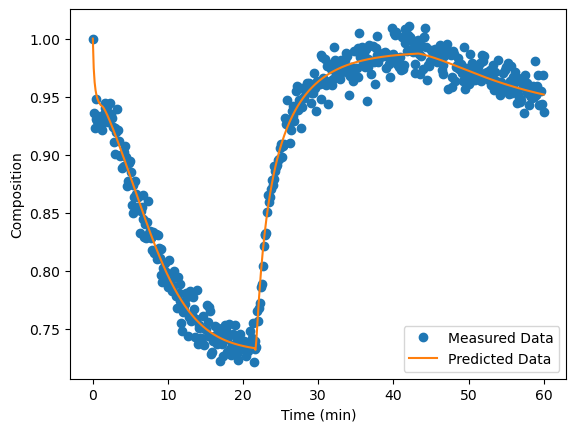

In [4]:
#%%
plt.plot(mhe.time,xd,"o",label = "Measured Data")
plt.plot(mhe.time,mhe.x[0], label = "Predicted Data")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Composition")

# MPC Controller

In [5]:
from gekko import GEKKO
import matplotlib.pyplot as plt
import numpy as np

# Initialize GEKKO model
mpc = GEKKO()

# nt minute time horizon with steps every steps
nt = 60
steps = 1
mpc.time = np.linspace(0,nt,int(nt/steps))

# Parameters
#Reflux Ratio
rr_ss = 3
rr = np.ones(len(mpc.time)) * rr_ss
mpc.rr = mpc.MV(value=rr, lb=0.1, ub=10)
mpc.rr.STATUS = 1 #Controller changes reflux ratio to reach setpoint
mpc.rr.FSTATUS = 0 #reflux ratio does not recieve measurements
mpc.DMAX = 1
mpc.COST = 0
mpc.DCOST = 0

#Feed rate
mpc.Feed = mpc.Param(value=1)
#Feed Composition
mpc.x_Feed = mpc.Param(value=0.5)

# Variables
#start the column at steady state
x_ss =np.array([0.935,0.900,0.862,0.821,0.779,0.738,\
0.698,0.661,0.628,0.599,0.574,0.553,0.535,0.521,    \
0.510,0.501,0.494,0.485,0.474,0.459,0.441,0.419,    \
0.392,0.360,0.324,0.284,0.243,0.201,0.161,0.125,    \
0.092,0.064])
x0 = x_ss
#Liquid Composition of each position in the column
mpc.x = []
for i in range(0,32):
    if(i!=0):
        mpc.x.append(mpc.SV(value=x0[i]))
    else:
        mpc.x.append(mpc.CV(value=x0[i]))
mpc.x[0].FSTATUS = 0 #recieve measurement for distillate composition
mpc.x[0].MEAS_GAP = 0.01 #Don't worry about the noise
mpc.x[0].STATUS = 1 #minimize error of x[0]
mpc.x[0].TR_INIT = 1 #traget a trajectory to new setpoint
mpc.x[0].TAU = 10 # Time constant for response

    
#Parameters to receive from estimator
# Equilibrium constant (relative volatilities)
mpc.vol = mpc.FV(value = 1.6)
# Total Molar Holdup in the Condenser
mpc.atray = mpc.FV(value = 0.25)
# Total Molar Holdup on each Tray
mpc.acond = mpc.FV(value = 0.5)
# Total Molar Holdup in the Reboiler
mpc.areb = mpc.FV(value = 1.0)


# Distillate Flowrate (mol/min)
mpc.D = mpc.Intermediate(0.5*mpc.Feed)

# Flowrate of the Liquid in the Rectification Section (mol/min)
mpc.L = mpc.Intermediate(mpc.rr*mpc.D)

# Vapor Flowrate in the Column (mol/min)
mpc.V = mpc.Intermediate(mpc.L+mpc.D)

# Flowrate of the Liquid in the Stripping Section (mol/min)
mpc.FL = mpc.Intermediate(mpc.Feed+mpc.L)

# Vapor Mole Fractions of Component A
# From the equilibrium assumption and mole balances
# 1) vol = (yA/xA) / (yB/xB)
# 2) xA + xB = 1
# 3) yA + yB = 1
mpc.y = [mpc.Intermediate(mpc.x[i]*mpc.vol/(1.0+(mpc.vol-1.0)*mpc.x[i])) for i in range(32)]

# Material Balances on Each Tray

mpc.Equation(mpc.x[0].dt() == 1/mpc.acond*mpc.V*(mpc.y[1]-mpc.x[0]))
for i in range(1,16):
    mpc.Equation(mpc.x[i].dt() == 1.0/mpc.atray*(mpc.L*(mpc.x[i-1]-mpc.x[i])-mpc.V*(mpc.y[i]-mpc.y[i+1])))
mpc.Equation(mpc.x[16].dt() == 1/mpc.atray*(mpc.Feed*mpc.x_Feed+mpc.L*mpc.x[15]-mpc.FL*mpc.x[16]-mpc.V*(mpc.y[16]-mpc.y[17])))
for i in range(17,31):
    mpc.Equation(mpc.x[i].dt() == 1.0/mpc.atray*(mpc.FL*(mpc.x[i-1]-mpc.x[i])-mpc.V*(mpc.y[i]-mpc.y[i+1])))
mpc.Equation(mpc.x[31].dt() == 1/mpc.areb*(mpc.FL*mpc.x[30]-(mpc.Feed-mpc.D)*mpc.x[31]-mpc.V*mpc.y[31]))


# Set options
mpc.options.IMODE = 6
mpc.options.NODES = 3
mpc.options.EV_TYPE = 1
mpc.options.SOLVER = 3

print("MPC Model Created")

MPC Model Created


# Test MPC Model with One Time Step

apm 66.219.236.230_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           39
   Intermediates:           36
   Connections  :            0
   Equations    :           68
   Residuals    :           32
 
 Number of state variables:           9204
 Number of total equations: -         9145
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             59
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo

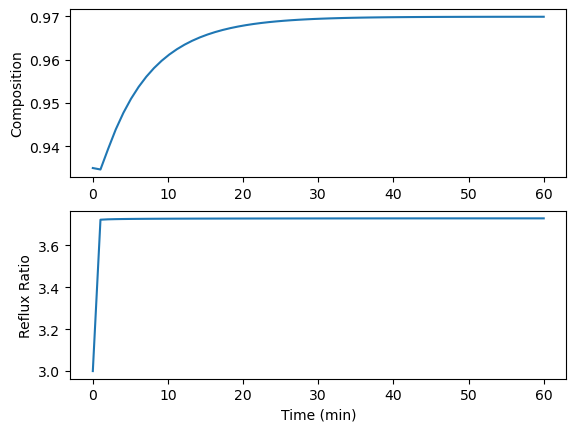

In [6]:
#Give Set Point
mpc.x[0].SPHI = 0.98
mpc.x[0].SPLO = 0.97
# Predict Parameters
mpc.solve(disp = True)

plt.subplot(2,1,1)
plt.plot(mpc.time,mpc.x[0])
plt.ylabel("Composition")
plt.subplot(2,1,2)
plt.ylabel("Reflux Ratio")
plt.plot(mpc.time,mpc.rr,)
plt.xlabel("Time (min)")
plt.show()

# MPC/MHE/ODEINT without sleep

In [85]:
####### CONTROLLER SETUP
import time
# Initialize GEKKO model
mhe = GEKKO()

#Time horizon estimator THIS MUST MATCH WITH TIME STEP OF CONTROLLER
ntmhe = 40
mhe.time = np.linspace(0,ntmhe*3,ntmhe+1)

# Parameters
#Reflux Ratio
rr_ss = 3
rr = np.ones(len(mhe.time)) * rr_ss
rr[10:] = 1.0
rr[180:] = 5.0
rr[360:] = 3.0
mhe.rr = mhe.MV(value=rr, lb=0.1, ub=10)
mhe.rr.STATUS = 0 #reflux ratio not optimized in estimator
mhe.rr.FSTATUS = 0 #reflux ratio does not recieve measurements
#Feed rate
mhe.Feed = mhe.FV(value=1)
#mhe.Feed.STATUS = 0 #Feed not optimized in estimator
#Feed Composition
mhe.x_Feed = mhe.FV(value=0.5)
#mhe.x_Feed.STATUS = 0 #xf not optimized in estimator

# Variables
#start the column at steady state
x_ss =np.array([0.935,0.900,0.862,0.821,0.779,0.738,\
0.698,0.661,0.628,0.599,0.574,0.553,0.535,0.521,    \
0.510,0.501,0.494,0.485,0.474,0.459,0.441,0.419,    \
0.392,0.360,0.324,0.284,0.243,0.201,0.161,0.125,    \
0.092,0.064])
x0 = x_ss
#Liquid Composition of each position in the column
mhe.x = []
for i in range(0,32):
    if(i!=0):
        mhe.x.append(mhe.SV(value=x0[i]))
    else:
        mhe.x.append(mhe.CV(value=x0[i]))
mhe.x[0].FSTATUS = 1 #recieve measurement for distillate composition
mhe.x[0].MEAS_GAP = 0.01
mhe.x[0].STATUS = 1 #minimize error of x[0]


    
#ESTIMATOR PARAMETERS
# Equilibrium constant (relative volatilities)
mhe.vol = mhe.FV(value = 1.6)
mhe.vol.FSTATUS = 0 # We don't receive measurements for relative volatility
mhe.vol.DMAX = 0.1
mhe.vol.LOWER = 1.2
mhe.vol.UPPER = 2
# Total Molar Holdup in the Condenser
mhe.atray = mhe.FV(value = 0.25)
mhe.atray.FSTATUS = 0
mhe.atray.DMAX = 0.1
mhe.atray.LOWER = 0.1
mhe.atray.UPPER = 1
# Total Molar Holdup on each Tray
mhe.acond = mhe.FV(value = 0.5)
mhe.acond.FSTATUS = 0
mhe.acond.DMAX = 0.1
mhe.acond.LOWER = 0.2
mhe.acond.UPPER = 0.7
# Total Molar Holdup in the Reboiler
mhe.areb = mhe.FV(value = 1.0)
mhe.areb.FSTATUS = 0
mhe.areb.DMAX = 0.1
mhe.areb.LOWER = 0.5
mhe.areb.UPPER = 1.5


# Distillate Flowrate (mol/min)
mhe.D = mhe.Intermediate(0.5*mhe.Feed)

# Flowrate of the Liquid in the Rectification Section (mol/min)
mhe.L = mhe.Intermediate(mhe.rr*mhe.D)

# Vapor Flowrate in the Column (mol/min)
mhe.V = mhe.Intermediate(mhe.L+mhe.D)

# Flowrate of the Liquid in the Stripping Section (mol/min)
mhe.FL = mhe.Intermediate(mhe.Feed+mhe.L)

# Vapor Mole Fractions of Component A
# From the equilibrium assumption and mole balances
# 1) vol = (yA/xA) / (yB/xB)
# 2) xA + xB = 1
# 3) yA + yB = 1
mhe.y = [mhe.Intermediate(mhe.x[i]*mhe.vol/(1.0+(mhe.vol-1.0)*mhe.x[i])) for i in range(32)]

# Material Balances on Each Tray

mhe.Equation(mhe.x[0].dt() == 1/mhe.acond*mhe.V*(mhe.y[1]-mhe.x[0]))
for i in range(1,16):
    mhe.Equation(mhe.x[i].dt() == 1.0/mhe.atray*(mhe.L*(mhe.x[i-1]-mhe.x[i])-mhe.V*(mhe.y[i]-mhe.y[i+1])))
mhe.Equation(mhe.x[16].dt() == 1/mhe.atray*(mhe.Feed*mhe.x_Feed+mhe.L*mhe.x[15]-mhe.FL*mhe.x[16]-mhe.V*(mhe.y[16]-mhe.y[17])))
for i in range(17,31):
    mhe.Equation(mhe.x[i].dt() == 1.0/mhe.atray*(mhe.FL*(mhe.x[i-1]-mhe.x[i])-mhe.V*(mhe.y[i]-mhe.y[i+1])))
mhe.Equation(mhe.x[31].dt() == 1/mhe.areb*(mhe.FL*mhe.x[30]-(mhe.Feed-mhe.D)*mhe.x[31]-mhe.V*mhe.y[31]))


# Set options
mhe.options.IMODE = 5
mhe.options.NODES = 3
mhe.options.EV_TYPE = 1
mhe.options.SOLVER = 3

print("MHE Model Created")

# Initialize GEKKO model
mpc = GEKKO()

# nt minute time horizon with steps every steps
#Time horizon mpc
ntmpc = 60
stepsmpc = 1
mpc.time = np.linspace(0,ntmpc,int(ntmpc/stepsmpc))

# Parameters
#Reflux Ratio
rr_ss = 3
rr = np.ones(len(mpc.time)) * rr_ss
mpc.rr = mpc.MV(value=rr, lb=0.1, ub=10)
mpc.rr.STATUS = 1 #Controller changes reflux ratio to reach setpoint
mpc.rr.FSTATUS = 0 #reflux ratio does not recieve measurements
mpc.DMAX = 1
mpc.COST = 0
mpc.DCOST = 0

#Feed rate
mpc.Feed = mpc.Param(value=1)
#Feed Composition
mpc.x_Feed = mpc.Param(value=0.5)

# Variables
#start the column at steady state
x_ss =np.array([0.935,0.900,0.862,0.821,0.779,0.738,\
0.698,0.661,0.628,0.599,0.574,0.553,0.535,0.521,    \
0.510,0.501,0.494,0.485,0.474,0.459,0.441,0.419,    \
0.392,0.360,0.324,0.284,0.243,0.201,0.161,0.125,    \
0.092,0.064])
x0 = x_ss
#Liquid Composition of each position in the column
mpc.x = []
for i in range(0,32):
    if(i!=0):
        mpc.x.append(mpc.SV(value=x0[i]))
    else:
        mpc.x.append(mpc.CV(value=x0[i]))
mpc.x[0].FSTATUS = 0 #recieve measurement for distillate composition
mpc.x[0].MEAS_GAP = 0.01 #Don't worry about the noise
mpc.x[0].STATUS = 1 #minimize error of x[0]
mpc.x[0].TR_INIT = 1 #traget a trajectory to new setpoint
mpc.x[0].TAU = 10 # Time constant for response

    
#Parameters to receive from estimator
# Equilibrium constant (relative volatilities)
mpc.vol = mpc.FV(value = 1.6)
# Total Molar Holdup in the Condenser
mpc.atray = mpc.FV(value = 0.25)
# Total Molar Holdup on each Tray
mpc.acond = mpc.FV(value = 0.5)
# Total Molar Holdup in the Reboiler
mpc.areb = mpc.FV(value = 1.0)


# Distillate Flowrate (mol/min)
mpc.D = mpc.Intermediate(0.5*mpc.Feed)

# Flowrate of the Liquid in the Rectification Section (mol/min)
mpc.L = mpc.Intermediate(mpc.rr*mpc.D)

# Vapor Flowrate in the Column (mol/min)
mpc.V = mpc.Intermediate(mpc.L+mpc.D)

# Flowrate of the Liquid in the Stripping Section (mol/min)
mpc.FL = mpc.Intermediate(mpc.Feed+mpc.L)

# Vapor Mole Fractions of Component A
# From the equilibrium assumption and mole balances
# 1) vol = (yA/xA) / (yB/xB)
# 2) xA + xB = 1
# 3) yA + yB = 1
mpc.y = [mpc.Intermediate(mpc.x[i]*mpc.vol/(1.0+(mpc.vol-1.0)*mpc.x[i])) for i in range(32)]

# Material Balances on Each Tray

mpc.Equation(mpc.x[0].dt() == 1/mpc.acond*mpc.V*(mpc.y[1]-mpc.x[0]))
for i in range(1,16):
    mpc.Equation(mpc.x[i].dt() == 1.0/mpc.atray*(mpc.L*(mpc.x[i-1]-mpc.x[i])-mpc.V*(mpc.y[i]-mpc.y[i+1])))
mpc.Equation(mpc.x[16].dt() == 1/mpc.atray*(mpc.Feed*mpc.x_Feed+mpc.L*mpc.x[15]-mpc.FL*mpc.x[16]-mpc.V*(mpc.y[16]-mpc.y[17])))
for i in range(17,31):
    mpc.Equation(mpc.x[i].dt() == 1.0/mpc.atray*(mpc.FL*(mpc.x[i-1]-mpc.x[i])-mpc.V*(mpc.y[i]-mpc.y[i+1])))
mpc.Equation(mpc.x[31].dt() == 1/mpc.areb*(mpc.FL*mpc.x[30]-(mpc.Feed-mpc.D)*mpc.x[31]-mpc.V*mpc.y[31]))


# Set options
mpc.options.IMODE = 6
mpc.options.NODES = 3
mpc.options.EV_TYPE = 1
mpc.options.SOLVER = 3

print("MPC Model Created")

########

#Allow MPC controller to accept measured values from estimator
mpc.vol.FSTATUS = 1
mpc.areb.FSTATUS = 1
mpc.acond.FSTATUS = 1
mpc.atray.FSTATUS = 1



#Final Time
tf = 10 #min
#Number of Data Points (every 3 seconds)
n = int(tf*20) + 1
xDm = np.zeros(n)
xDm[0] = x_ss[0]
SMAX = 3 #in seconds


#Desired set point
xDsp = np.ones(n)*0.99

#Reflux Decisions
r_ss = 3
RRs = np.ones(n)*r_ss

#Feed Comp
Feeds = np.ones(n)*1
xfs = np.ones(n)*0.5

#Estimator Decisions
vol_plt = np.ones(n)
areb_plt = np.ones(n)
acond_plt = np.ones(n)
atray_plt = np.ones(n)

#Main Loop for Controller
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)
t = 0


try:
    for i in range(1,n-1):
        dt = SMAX #Assumes instantaneous control decisions
        tm[i] = dt*i/60 # in min

        # Turn on parameter estimation after 10 cycles
        if i==50:
            mhe.vol.STATUS = 1 
            mhe.areb.STATUS = 1
            mhe.acond.STATUS = 1
            mhe.atray.STATUS = 1

        # Get Distillate Compositions from Simulator
        res = 10
        tsim = np.linspace(0,tm[i],i*res) 
        rsim = np.ones(i*res)
        feedsim = np.ones(i*res)
        xfsim = np.ones(i*res)
        
        w = 0
        for j in range(0,i*res):
            if(j%res==0):
                rsim[j] = RRs[w]
                feedsim[j] = Feeds[w]
                xfsim[j] = xfs[w]
                if(j != 0):
                    w += 1
            else:
                rsim[j] = RRs[w]
                feedsim[j] = Feeds[w]
                xfsim[j] = xfs[w]
        xDm[i] = simulate(tsim,rsim,feedsim,xfsim,x_ss)[-1]

        # Insert measurements to MHE
        mhe.x[0].MEAS = xDm[i]

        # Update model parameters with MHE
        try:
            mhe.solve(disp=False)

            # Insert updated parameters to MPC
            mpc.vol.MEAS = mhe.vol.NEWVAL
            mpc.areb.MEAS = mhe.areb.NEWVAL
            mpc.acond.MEAS = mhe.acond.NEWVAL
            mpc.atray.MEAS = mhe.atray.NEWVAL
            
            vol_plt[i] = mhe.vol.NEWVAL
            areb_plt[i] = mhe.areb.NEWVAL
            acond_plt[i] = mhe.acond.NEWVAL
            atray_plt[i] = mhe.atray.NEWVAL
            
      
            print("Vol:",mhe.vol.NEWVAL)
        except:
            print('MHE solution failed, using prior values')

        # Insert temperature measurement for MPC
        mpc.x[0].MEAS = xDm[i]

        # Adjust setpoints
        db1 = 0.01 # dead-band
        mpc.x[0].SPHI = xDsp[i] + db1
        mpc.x[0].SPLO = xDsp[i] - db1


        # Adjust Heaters with MPC
        try:
            # Solve MPC
            mpc.solve(disp=False)

            RRs[i+1] = mpc.rr.NEWVAL
            # get additional solution information
           # with open(mpc.path+'//results.json') as f:
            #    results = json.load(f)
            print("RR:",RRs[i+1])
        except:
            print('MPC solution failed. Set Reflux Ratio to r_ss')
            RRs[i+1] =r_ss
        #If last pull simulator results
        if(i==(n-2)):
            xDm_plt = simulate(tsim,rsim,feedsim,xfsim,x_ss)
except KeyboardInterrupt:
    print("User Shutdown")

MHE Model Created
MPC Model Created
Vol: 1.6
RR: 4.1826003217
Vol: 1.6
RR: 4.1828316161
Vol: 1.6
RR: 4.182642027
Vol: 1.6
RR: 4.1826084331
Vol: 1.6
RR: 4.1835033508
Vol: 1.6
RR: 4.1848026275
Vol: 1.6
RR: 4.1854328672
Vol: 1.6
RR: 4.1853810735
Vol: 1.6
RR: 4.186457074
Vol: 1.6
RR: 4.1868895422
Vol: 1.6
RR: 4.1873495954
Vol: 1.6
RR: 4.1878759062
Vol: 1.6
RR: 4.1884531631
Vol: 1.6
RR: 4.188932028
Vol: 1.6
RR: 4.3310459898
Vol: 1.6
RR: 4.3305173625
Vol: 1.6
RR: 4.330304365
Vol: 1.6
RR: 4.3302119594
Vol: 1.6
RR: 4.3300442073
Vol: 1.6
RR: 4.3299197331
Vol: 1.6
RR: 4.3295952748
Vol: 1.6
RR: 4.3295488475
Vol: 1.6
RR: 4.3293126696
Vol: 1.6
RR: 4.3289406607
Vol: 1.6
RR: 4.3289523029
Vol: 1.6
RR: 4.3285482789
Vol: 1.6
RR: 4.328164255
Vol: 1.6
RR: 4.3278397735
Vol: 1.6
RR: 4.3274020421
Vol: 1.6
RR: 4.3269020079
Vol: 1.6
RR: 4.3264765629
Vol: 1.6
RR: 4.3256755744
Vol: 1.6
RR: 4.3254524766
Vol: 1.6
RR: 4.3255051114
Vol: 1.6
RR: 4.324672404
Vol: 1.6
RR: 4.3246193631
Vol: 1.6
RR: 4.3246720817
Vol: 1.6

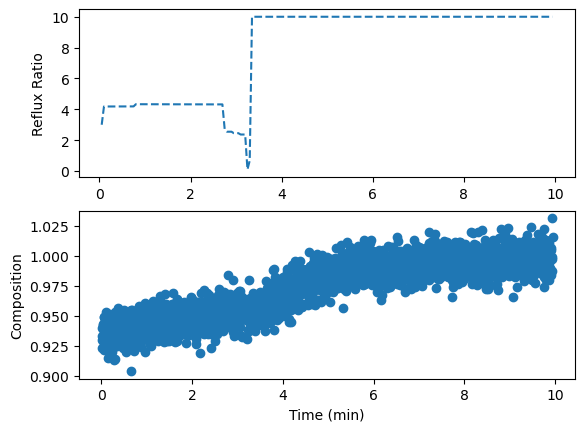

In [87]:
plt.subplot(2,1,1)
plt.plot(tm[1:n-1],RRs[1:n-1],"--")
plt.ylabel("Reflux Ratio")
plt.subplot(2,1,2)
plt.plot(tsim[1:],xDm_plt[1:],"o",label = "Simulated Distillate Composition")

#plt.plot(mpc.time,mpc.x[0].value,"--")
plt.ylabel("Composition")
plt.xlabel("Time (min)")
plt.show()


In [82]:
xDm_plt

array([1.        , 0.93418009, 0.9316336 , 0.93008293, 0.93668847,
       0.93444352, 0.91519766, 0.91706899, 0.92310227, 0.937455  ,
       0.928265  , 0.95272673, 0.95006151, 0.9256994 , 0.93543994,
       0.92546554, 0.92956649, 0.91268565, 0.93593575, 0.93421359,
       0.93663661, 0.92837339, 0.93293539, 0.94073648, 0.9203412 ,
       0.9391149 , 0.94651897, 0.94772458, 0.93706057, 0.95616593,
       0.92638131, 0.94302645, 0.931125  , 0.94504621, 0.93546583,
       0.93041541, 0.92886677, 0.94297648, 0.93478246, 0.93800696,
       0.91775327, 0.92456508, 0.9277801 , 0.93549654, 0.93645396,
       0.94374116, 0.93845352, 0.95174752, 0.94156207, 0.94483188,
       0.9382679 , 0.96151721, 0.92480085, 0.92869212, 0.94362124,
       0.92644371, 0.93367026, 0.94068638, 0.90691812, 0.92545529,
       0.93332622, 0.92790656, 0.92657648, 0.94052843, 0.9464262 ,
       0.92925565, 0.93612567, 0.94869047, 0.94724387, 0.94206778,
       0.93255002, 0.92753758, 0.92510442, 0.93596667, 0.93259

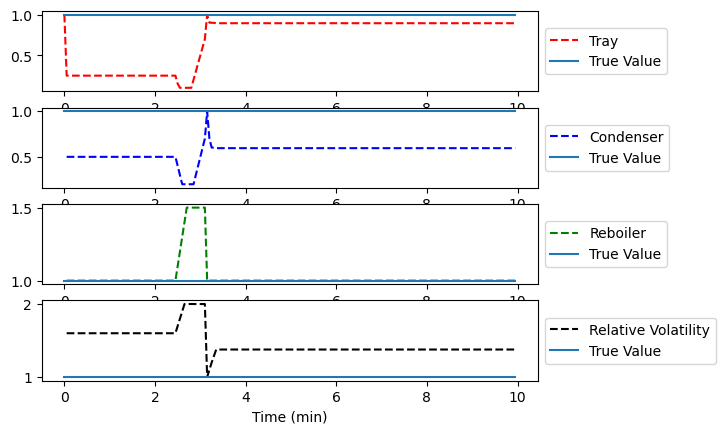

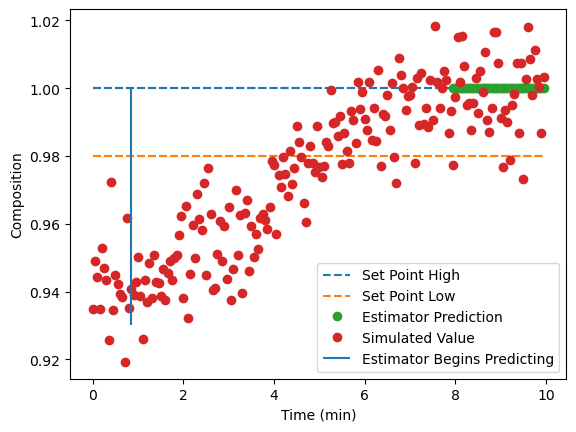

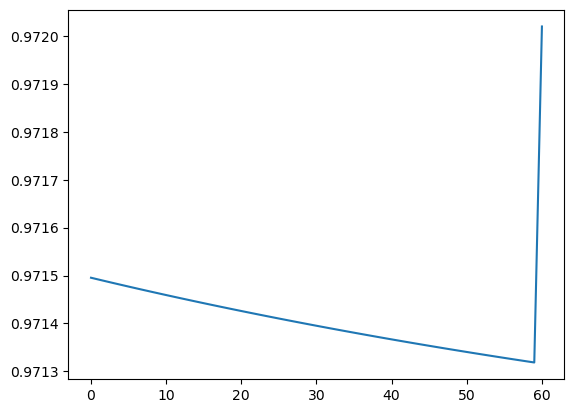

In [98]:
plt.subplot(4,1,1)
plt.plot(tm[0:n-1],atray_plt[0:n-1],"r--",label ="Tray")
plt.plot(tm[0:n-1],np.ones(len(tm[0:n-1]))*atray_plt[0],label = "True Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(4,1,2)
plt.plot(tm[1:n-1],acond_plt[1:n-1],"b--",label ="Condenser")
plt.plot(tm[0:n-1],np.ones(len(tm[0:n-1]))*acond_plt[0],label = "True Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(4,1,3)
plt.plot(tm[1:n-1],areb_plt[1:n-1],"g--",label ="Reboiler")
plt.plot(tm[0:n-1],np.ones(len(tm[0:n-1]))*areb_plt[0],label = "True Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(4,1,4)
plt.plot(tm[1:n-1],vol_plt[1:n-1],"k--",label="Relative Volatility")
plt.plot(tm[0:n-1],np.ones(len(tm[0:n-1]))*vol_plt[0],label = "True Value")
plt.xlabel("Time (min)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.plot(tm,xDsp+0.01,"--", label = "Set Point High")
plt.plot(tm,xDsp-0.01,"--", label = "Set Point Low")
plt.plot(tm[-42:-1],mhe.x[0].value, "o",label ="Estimator Prediction")
plt.plot(tm[0:n-1],xDm[0:n-1],"o",label = "Simulated Value")
plt.vlines(50/60,0.93,1,label = "Estimator Begins Predicting")
plt.xlabel("Time (min)")
plt.ylabel("Composition")
plt.legend()
plt.show()
plt.plot(mpc.time,mpc.x[0].value)

In [55]:
xDm

array([0.935     , 0.93719117, 0.9336606 , 0.94514946, 0.93008619,
       0.93130036, 0.93759822, 0.93558636, 0.92321812, 0.9454106 ,
       0.93485953, 0.94573117, 0.94600354, 0.93871194, 0.9433563 ,
       0.94226699, 0.93666457, 0.93677958, 0.94771535, 0.93800183,
       0.93230343, 0.93678791, 0.93986656, 0.93860907, 0.94147551,
       0.94041567, 0.94489907, 0.93750693, 0.94202418, 0.93596776,
       0.94400402, 0.94890577, 0.94032275, 0.94377436, 0.9433289 ,
       0.94191741, 0.94438989, 0.94001478, 0.93069893, 0.93705385,
       0.93800719, 0.94587607, 0.94669285, 0.95283361, 0.96115009,
       0.94866116, 0.94668387, 0.9530599 , 0.95243927, 0.93307637,
       0.9534112 , 0.94997856, 0.9482849 , 0.95384665, 0.95365348,
       0.96252421, 0.9435233 , 0.9692548 , 0.94525559, 0.97104302,
       0.96356031, 0.95887901, 0.94483892, 0.95956283, 0.95139224,
       0.9488099 , 0.97193424, 0.96221722, 0.96476818, 0.9595064 ,
       0.9419159 , 0.959602  , 0.95530259, 0.94598324, 0.94378

# Future Work Code

Code inserting a time delay for when you use this on the actual distillation tower

In [ ]:
import time

#Allow MPC controller to accept measured values from estimator
mpc.vol.FSTATUS = 1
mpc.areb.FSTATUS = 1
mpc.acond.FSTATUS = 1
mpc.atray.FSTATUS = 1



#Final Time
tf = 1 #min
#Number of Data Points (every 3 seconds)
n = tf*20 + 1
xDm = np.zeros(n)
xDm[0] = x_ss[0]
SMAX = 3

#Time horizon estimator
ntmhe = 100
mhe.time = np.linspace(0,60,ntmhe)

#Time horizon mpc
ntmpc = 60
stepsmpc = 1
mpc.time = np.linspace(0,ntmpc,int(ntmpc/stepsmpc))

#Desired set point
xDsp = np.ones(n)*0.98

#Reflux Decisions
r_ss = 3
RRs = np.ones(n)*r_ss

#Main Loop for Controller
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
    for i in range(1,n-1):
        # Sleep time
        sleep_max = SMAX
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = (t - start_time) # in min

        # Turn on parameter estimation after 10 cycles
        if i==10:
            mhe.vol.STATUS = 1 
            mhe.areb.STATUS = 1
            mhe.acond.STATUS = 1
            mhe.atray.STATUS = 1

        # Get Distillate Compositions from Simulator
        res = 10
        tsim = np.linspace(0,tm[i]/60,i*res) #in minutes
        rsim = np.ones(i*res)
        feedsim = np.ones(i*res)
        xfsim = np.ones(i*res)
        
        w = 0
        for j in range(0,i*res):
            if(j%res==0):
                rsim[w] = RRs[w]
                feedsim[w] = mhe.Feed.value[w]
                xfsim[w] = mhe.x_Feed.value[w]
                w += 1
        xDm[i] = simulate(tsim,rsim,feedsim,xfsim,x_ss)[-1]

        # Insert measurements to MHE
        mhe.x[0].MEAS = xDm[i]

        # Update model parameters with MHE
        try:
            mhe.solve(disp=False)

            # Insert updated parameters to MPC
            mpc.vol.MEAS = mhe.vol.NEWVAL
            mpc.areb.MEAS = mhe.areb.NEWVAL
            mpc.acond.MEAS = mhe.acond.NEWVAL
            mpc.atray.MEAS = mhe.atray.NEWVAL
            print("Vol:",mhe.vol.NEWVAL)
        except:
            print('MHE solution failed, using prior values')

        # Insert temperature measurement for MPC
        mpc.x[0].MEAS = xDm[i]

        # Adjust setpoints
        db1 = 0.01 # dead-band
        mpc.x[0].SPHI = xDsp[i] + db1
        mpc.x[0].SPLO = xDsp[i] - db1


        # Adjust Heaters with MPC
        try:
            # Solve MPC
            mpc.solve(disp=False)

            RRs[i+1] = mpc.rr.NEWVAL
            # get additional solution information
           # with open(mpc.path+'//results.json') as f:
            #    results = json.load(f)
            print("RR:",RRs[i+1])
        except:
            print('MPC solution failed. Set Reflux Ratio to r_ss')
            RRs[i+1] =r_ss
        #If last pull simulator results
        xDm_plt = simulate(tsim,rsim,feedsim,xfsim,x_ss)
except KeyboardInterrupt:
    print("User Shutdown")

# PID Performance on Feed Set Point Change

In [ ]:
# Steady State Initial Conditions for the 32 states
x_ss =np.array([0.935,0.900,0.862,0.821,0.779,0.738,\
0.698,0.661,0.628,0.599,0.574,0.553,0.535,0.521,    \
0.510,0.501,0.494,0.485,0.474,0.459,0.441,0.419,    \
0.392,0.360,0.324,0.284,0.243,0.201,0.161,0.125,    \
0.092,0.064])
x0 = x_ss

# Steady State Initial Condition
rr_ss = 3.0

# Time Interval (min)
ns = 101
t = np.linspace(0,100,ns)

# Store results for plotting
xd = np.ones(len(t)) * x_ss[0]
rr = np.ones(len(t)) * rr_ss
ff = np.ones(len(t))
xf = np.ones(len(t)) * 0.5

# Step in reflux ratio
#rr[10:] = 4.0
#rr[40:] = 2.0
#rr[70:] = 3.0

# Feed Concentration (mol frac)
xf[50:] = 0.42

# Feed flow rate
#ff[80:] = 1.0

delta_t = t[1]-t[0]

# storage for recording values
op = np.ones(ns)*3.0  # controller output
pv = np.zeros(ns)  # process variable
e = np.zeros(ns)   # error
ie = np.zeros(ns)  # integral of the error
dpv = np.zeros(ns) # derivative of the pv
P = np.zeros(ns)   # proportional
I = np.zeros(ns)   # integral
D = np.zeros(ns)   # derivative
sp = np.ones(ns)*0.935  # set point
sp[10:] = 0.97

# PID (tuning)
Kc = 60
tauI = 4
tauD = 0.0

# Upper and Lower limits on OP
op_hi = 10.0
op_lo = 1.0

# loop through time steps    
for i in range(1,ns):
    e[i] = sp[i] - pv[i]
    if i >= 1:  # calculate starting on second cycle
        dpv[i] = (pv[i]-pv[i-1])/delta_t
        ie[i] = ie[i-1] + e[i] * delta_t
    P[i] = Kc * e[i]
    I[i] = Kc/tauI * ie[i]
    D[i] = - Kc * tauD * dpv[i]
    op[i] = op[0] + P[i] + I[i] + D[i]
    if op[i] > op_hi:  # check upper limit
        op[i] = op_hi
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    if op[i] < op_lo:  # check lower limit
        op[i] = op_lo
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup

    # distillation solution (1 time step)
    rr[i] = op[i]
    ts = [t[i-1],t[i]]
    y = odeint(distill,x0,ts,args=(rr[i],ff[i],xf[i]))
    xd[i] = y[-1][0]
    x0 = y[-1]

    if i<ns-1:
        pv[i+1] = y[-1][0]

#op[ns] = op[ns-1]
#ie[ns] = ie[ns-1]
#P[ns] = P[ns-1]
#I[ns] = I[ns-1]
#D[ns] = D[ns-1]    


# Construct results and save data file
# Column 1 = time
# Column 2 = reflux ratio
# Column 3 = distillate composition
data = np.vstack((t,rr,xd)) # vertical stack
data = data.T             # transpose data
np.savetxt('data.txt',data,delimiter=',')

# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,rr,'b--',linewidth=3)
plt.ylabel(r'$RR$')
plt.legend(['Reflux ratio'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,xf,'k:',linewidth=3,label='Feed composition')
plt.plot(t,ff,'g-.',linewidth=3,label='Feed flow (mol/min)')
plt.ylabel('Feed')
plt.ylim([0.4,1.1])
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.plot(t,xd,'r-',linewidth=3)
plt.plot(t,sp,'k.-',linewidth=1)
plt.ylabel(r'$x_d\;(mol/L)$')
plt.legend(['Distillate composition','Set point'],loc='best')
plt.xlabel('Time (min)')
plt.savefig('distillation.png')
plt.show()